# Loading Data

In [18]:
import pandas as pd
from plotnine import *
from plotnine.data import *
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, precision_recall_curve
import numpy as np

pd.reset_option('^display.', silent=True)
#####################################################################
#### REPLACE THIS WITH THE PATH TO YOUR DATA ########################
#pathToTuningData = '/san2/data/change-exploration/roleMerging/finalExperiments/resultsFromTuning/data/changedata/roleMerging/tuningDataExport/'
#pathToTuningData = '/san2/data/change-exploration/roleMerging/finalExperiments/tuningDataExportNew/'
pathToTuningData = "/home/leon/data/dataset_versioning/finalExperiments/tuningResults/"
#####################################################################
#####################################################################

datasetToAbbreviation = {
'austintexas' : 'AU',
'chicago' : 'CH',
'gov.maryland' : 'MD',
'oregon' : 'OR',
'utah' : 'UT',
'education' : 'ED',
'football' : 'FO',
'military' : 'MI',
'politics' : 'PO',
'tv_and_film' : 'TV'
}

def readDF(source,name,fname):
    print("Reading",name)
    df = pd.read_csv(pathToTuningData + name + "/" + fname)
    df['dataset']=name
    df['datasetAbbreviated']=datasetToAbbreviation[name]
    df['datasource']=source
    df['isInterstingStrict'] = (df['interestingnessEvidence']>0) & (df['hasChangeAfterTrainPeriod'])
    df['isInterstingStrict'] = (df['hasChangeAfterTrainPeriod'])
    return df


#wikipedia:
dfPolitics = readDF('wikipedia','politics','tuningStats.csv')
dfMilitary = readDF('wikipedia','military','tuningStats.csv')
dfFootball = readDF('wikipedia','football','tuningStats.csv')
dfTV = readDF('wikipedia','tv_and_film','tuningStats.csv')
dfEducation = readDF('wikipedia','education','tuningStats.csv')
#dfMusic = readDF('wikipedia','music','music_stats.csv')
#socrata
dfAustin = readDF('socrata','austintexas','tuningStats.csv')
dfChicago = readDF('socrata','chicago','tuningStats.csv')
dfMaryland = readDF('socrata','gov.maryland','tuningStats.csv')
dfOregon = readDF('socrata','oregon','tuningStats.csv')
dfUtah = readDF('socrata','utah','tuningStats.csv')
print(dfUtah.columns)



Reading politics
Reading military
Reading football
Reading tv_and_film
Reading education
Reading austintexas
Reading chicago
Reading gov.maryland
Reading oregon
Reading utah
Index(['Vertex1ID', 'Vertex2ID', 'trainEndDate', 'remainsValidFullTimeSpan',
       'isValidSuperStrict', 'isValidFirstChangeAfter',
       'hasChangeAfterTrainPeriod', 'interestingnessEvidence',
       'strongPositive_count', 'weakPositive_count', 'neutral_count',
       'weakNegative_count', 'strongNegative_count', 'strongPositive_scoreSum',
       'weakPositive_scoreSum', 'neutral_scoreSum', 'weakNegative_scoreSum',
       'strongNegative_scoreSum', 'dataset', 'datasetAbbreviated',
       'datasource', 'isInterstingStrict'],
      dtype='object')


In [19]:
#organize dataframes:
allDfsSocrata=[dfAustin,dfChicago,dfMaryland,dfOregon,dfUtah]
allDfsWikipedia=[dfPolitics,dfMilitary,dfFootball,dfTV,dfEducation] #dfMusic
#allDfsWikipedia=[dfFootball]
#dfMusic# #allDfsWikipedia=[]
allDfs = allDfsSocrata+allDfsWikipedia
#df = dfPolitics.append(dfMilitary).append(dfAustin).append(dfChicago).append(dfMaryland).append(dfOregon).append(dfUtah)#.append(dfFootball)

# Aggregate General Statistics

In [20]:
def aggregateInfoForDF(curDf,rowList):
    validRowsStrictFull = curDf[curDf['remainsValidFullTimeSpan']]
    isInterstingStrictFull = curDf[curDf['isInterstingStrict']]
    validRelFrequencyFull=len(validRowsStrictFull.index)/len(curDf.index)
    canBeEvaluatedRelFrequencyFull=len(isInterstingStrictFull.index)/len(curDf.index)
    validRowsOfInterestingFull = isInterstingStrictFull[isInterstingStrictFull['remainsValidFullTimeSpan']]
    if(len(isInterstingStrictFull.index)==0):
        validRelFrequencyFullOfInteresting=np.NAN
    else:
        validRelFrequencyFullOfInteresting=len(validRowsOfInterestingFull.index)/len(isInterstingStrictFull.index)
    dict1 = {"dataset": curDf['dataset'].iloc[0], 
                     "trainEndDate": curDf['trainEndDate'].iloc[0],
                     "nEdges":len(curDf.index),
                     "validPercentageFullTimePeriod":validRelFrequencyFull,
                     "validPercentageFullTimePeriodOfInteresting":validRelFrequencyFullOfInteresting,
                     "canBeEvaluatedPercentageFullTimePeriod":canBeEvaluatedRelFrequencyFull
            }
    rowList.append(dict1)
    
def processDFList(dfs):    
    rowList=[]
    for df in dfs:
        byTrainTimeEnd = df.groupby('trainEndDate')    
        subDFs = [byTrainTimeEnd.get_group(x) for x in byTrainTimeEnd.groups]
        for subDF in subDFs:
            aggregateInfoForDF(subDF,rowList)
    toReturn=pd.DataFrame(rowList)
    return toReturn
    
aggregateStatSocrataDF=processDFList(allDfsSocrata)
aggregateStatWikipediaDF=processDFList(allDfsWikipedia)
print(aggregateStatSocrataDF)
#rint(aggregateStatWikipediaDF)

        dataset trainEndDate  nEdges  validPercentageFullTimePeriod  \
0   austintexas   2020-04-30  999529                       0.477930   
1       chicago   2020-04-30  647794                       0.384846   
2  gov.maryland   2020-04-30  149890                       0.155774   
3        oregon   2020-04-30   48555                       0.356194   
4          utah   2020-04-30    8190                       0.807082   

   validPercentageFullTimePeriodOfInteresting  \
0                                    0.147212   
1                                    0.062936   
2                                    0.150009   
3                                    0.236803   
4                                    0.802404   

   canBeEvaluatedPercentageFullTimePeriod  
0                                0.612114  
1                                0.656423  
2                                0.993155  
3                                0.841973  
4                                0.975092  


# Plot Validity over Matching Data

In [21]:
dateToPercentageSocrata = {
    '2020-04-30' : 49,
    '2020-05-31' : 58,
    '2020-06-30' : 66,
    '2020-07-31' : 75,
    '2020-08-31' : 83,
    '2020-09-30' : 91
}
dateToPercentageWikipedia = {
'2011-05-07' : 50,
'2012-05-05' : 56,
'2013-05-04' : 62,
'2014-05-03' : 68,
'2015-05-02' : 74,
'2016-05-07' : 80,
'2017-04-29' : 86,
'2018-04-28' : 92, 
}

datasetToAbbreviation = {
'austintexas' : 'AU',
'chicago' : 'CH',
'gov.maryland' : 'MD',
'oregon' : 'OR',
'utah' : 'UT',
'education' : 'ED',
'football' : 'FO',
'military' : 'MI',
'politics' : 'PO',
'tv_and_film' : 'TV'
}

#TODO: map dates to percentages!
aggregateStatSocrataDF=aggregateStatSocrataDF[aggregateStatSocrataDF['trainEndDate'] != '2020-10-31']
aggregateStatSocrataDF["matchingTimePercentage"] = list(map(lambda x : dateToPercentageSocrata[x],list(aggregateStatSocrataDF['trainEndDate'])))
aggregateStatWikipediaDF["matchingTimePercentage"] = list(map(lambda x : dateToPercentageWikipedia[x],list(aggregateStatWikipediaDF['trainEndDate'])))
aggregateStatSocrataDF['datasource'] = "socrata"
aggregateStatWikipediaDF['datasource'] = "wikipedia"


totalAggregateDF = aggregateStatSocrataDF.append(aggregateStatWikipediaDF)
totalAggregateDF['dataset_long']=totalAggregateDF['dataset']
totalAggregateDF['dataset_unordered']= list(map(lambda x : datasetToAbbreviation[x],list(totalAggregateDF['dataset_long'])))

totalAggregateDF['dataset'] = pd.Categorical(totalAggregateDF['dataset_unordered'], ["AU","CH","MD","OR","UT","ED","FO","MI","PO","TV"])


def printAndSavePlots(df,datasource):
    plot = (ggplot(df, aes(x='matchingTimePercentage',ymin=0,ymax=1, y='validPercentageFullTimePeriodOfInteresting',group='dataset',color='dataset',shape="datasource", line='datasource')) 
      + geom_line(size=1.0) 
      + geom_point(size=4)
      + scale_x_continuous(name="Data used for matching [%]")
      + scale_y_continuous(name="Share of valid edges")
      + theme(text=element_text(size=14))
      #+ theme(axis_text_x=element_text(size=12),axis_text_y=element_text(size=12))
      + labs(title=''))
    print(plot)
    fname = 'exportedPlots/validityOverMatchingTime_' + datasource +'.jpg'
    plot.save(filename = fname)

#printAndSavePlots(totalAggregateDF,"lol")


/tmp/ipykernel_4162/98067179.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


# Filtering

In [22]:
#Only keep confirmed valid edges:
def filterDF(df):
    return df[((df['trainEndDate']=='2016-05-07') | (df['trainEndDate']=='2020-04-30')) & df['isInterstingStrict']]

allDfsFiltered = list(map(filterDF,allDfs))
for df in allDfsFiltered:
    print(df.iloc[0]['dataset'],"size:",len(df.index))

austintexas size: 611826
chicago size: 425227
gov.maryland size: 148864
oregon size: 40882
utah size: 7986
politics size: 4399
military size: 29792
football size: 6699
tv_and_film size: 5128
education size: 2769


In [23]:
y_pred = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]
y_test = [False,False,True,False,False,True,True,False]
targetPrecision = 0.65

precision, recall, thresholds = precision_recall_curve(y_test,y_pred)

def getDF(dfList,name):
    return list(filter(lambda x: x.iloc[0]['dataset']==name, dfList))[0]

print(precision)
print(recall)
print(thresholds)

[0.5        0.4        0.5        0.66666667 0.5        0.
 1.        ]
[1.         0.66666667 0.66666667 0.66666667 0.33333333 0.
 0.        ]
[0.3 0.4 0.5 0.6 0.7 0.8]


# Tuning

In [24]:
from random import random

def getRecallAtPrecision(targetPrecision,precision,recall,thresholds):
    earliestThresholdIndex = -1
    for i,p in enumerate(precision):
        if(p >= targetPrecision):
            earliestThresholdIndex = i
            #print(p)
            break;
    precisionWithoutLast = precision[:len(precision)-1]
    if(earliestThresholdIndex==-1):
        earliestThresholdIndex=np.argmax(precisionWithoutLast)
    if(earliestThresholdIndex==len(precision)-1):
        earliestThresholdIndex=np.argmax(precisionWithoutLast)
    return precision[earliestThresholdIndex],recall[earliestThresholdIndex],thresholds[earliestThresholdIndex]

def getDF(dfList,name):
    return list(filter(lambda x: x.iloc[0]['dataset']==name, dfList))[0]

def createScore(weights,dfFiltered):
    totalCount = np.where(dfFiltered['datasource']== 'wikipedia', 869, 364)
    scoreVector=((dfFiltered['strongPositive_scoreSum']/totalCount)*weights[0] + 
                        (dfFiltered['weakPositive_scoreSum']/totalCount)*weights[1] +
                        (dfFiltered['neutral_scoreSum']/totalCount)*weights[2] +
                        (dfFiltered['weakNegative_scoreSum']/totalCount)*weights[3] +
                        (dfFiltered['strongNegative_scoreSum']/totalCount)*weights[4])
    return scoreVector

def getRangeForThreshold(thresholds):
    ranges = []
    for i in range(len(thresholds)):
        if(i<len(thresholds)-1):
            ranges.append(thresholds[i+1]-thresholds[i])
        else:
            ranges.append(0)
    return np.array(ranges)

def appendF1DFEntry(dfForThisDsAndScore,rows_listF1,scoreName,y_pred,truthLabel,curWeights,curRatio):
    dsName=dfForThisDsAndScore['dataset'].iloc[0]
    #dfForThisDsAndScore = dfForThisDs[dfForThisDs[predScore].notnull()]
    y_test = dfForThisDsAndScore[truthLabel]
    precision, recall, thresholds = precision_recall_curve(y_test,y_pred)
    targetPrecisionP,targetPrecisionR,targetPrecisionT = getRecallAtPrecision(targetPrecision,precision,recall,thresholds)
    targetPrecisionF1 = 0.0
    if(targetPrecisionR+targetPrecisionP>0):
        targetPrecisionF1 = 2*targetPrecisionR*targetPrecisionP/(targetPrecisionR+targetPrecisionP)
    targetPrecisionAbsRecall = targetPrecisionR*len(y_test)
    indices = (precision !=0) | (recall!=0)
    precision = precision[indices]
    recall = recall[indices]
    thresholds = thresholds[indices[0:len(indices)-1]]
    ranges = getRangeForThreshold(thresholds)
    f1_scores = 2*recall*precision/(recall+precision)
    f1_scores=f1_scores[0:len(f1_scores)-1]
    bestThresholdIndex=np.argmax(f1_scores)
    precision=precision[0:len(precision)-1]
    recall=recall[0:len(recall)-1]
    thisRange = ranges[bestThresholdIndex]
    maxRange = np.max(ranges)
    avgRange = np.mean(ranges)
    dict1 = {"dataset": dsName,
             "scoreName": scoreName,
             "targetPrecisionBestThreshold:": targetPrecisionT,
             "targetPrecisionPrecision:": targetPrecisionP,
             "targetPrecisionRecall:": targetPrecisionR,
             "targetPrecisionF1:": targetPrecisionF1,
             "targetPrecisionAbsRecall": targetPrecisionAbsRecall,
             "bestThreshold": thresholds[bestThresholdIndex],
             "best_F1":f1_scores[bestThresholdIndex],#np.max(f1_scores),
             "precision":precision[bestThresholdIndex],
             "recall":recall[bestThresholdIndex],
             "strongPositiveWeight":curWeights[0],
             "weakPositiveWeight":curWeights[1],
             "neutralWeight":curWeights[2],
             "weakNegativeWeight":curWeights[3],
             "strongNegativeWeight":curWeights[4],
             "pr":curRatio['pr'],
             "nr":curRatio['nr'],
             "nTOp":curRatio['nTOp'],
             "ThresholdRange":thisRange,
             "ThresholdRangeMax":maxRange,
             "ThresholdRangeAvg":avgRange
            }
    rows_listF1.append(dict1)
    
ratiosToTest = [1.0,0.8,0.6,0.4,0.2,0.1,0.01,0.001,0.0001]
ratiosNegativeToPositive = [100.0,10.0,5.0,1.0,0.5,0.1,0.01]
scoreNames=[]
allWeights={}
allRatios={}

rows_listF1 = []
targetPrecision = 0.85
#TVDfs = filter(lambda x: x.iloc[0]['dataset']=="tv_and_film",allDfsFiltered)
for curDF in allDfsFiltered:
    dsName=curDF['dataset'].iloc[0]
    print("Processing",dsName)
    for positiveRatio in ratiosToTest:
        for negativeRatio in ratiosToTest:
            for negativeToPositiveRatio in ratiosNegativeToPositive:
                if(negativeToPositiveRatio<=1):
                    weights = [1.0,positiveRatio*1.0,0,-negativeRatio*1.0*negativeToPositiveRatio,-1.0*negativeToPositiveRatio]
                    scoreName="score_pr:"+str(positiveRatio) + "_nr:" + str(negativeRatio) + "_nTOp:"+str(negativeToPositiveRatio)
                else:
                    positiveToNegativeRatio = 1/negativeToPositiveRatio
                    weights = [1.0*positiveToNegativeRatio,positiveToNegativeRatio*positiveRatio*1.0,0,-negativeRatio*1.0,-1.0]
                    scoreName="score_pr:"+str(positiveRatio) + "_nr:" + str(negativeRatio) + "_pTOn:"+str(positiveToNegativeRatio)
                allWeights[scoreName]=weights
                curRatio = {'pr':positiveRatio,'nr':negativeRatio,'nTOp':negativeToPositiveRatio}
                allRatios[scoreName]=curRatio
                scoreNames.append(scoreName)
                #print(weights)
                scoreVector = createScore(weights,curDF)
                #appendF1DFEntry(dfForThisDsAndScore,rows_listF1,scoreName,y_pred,truthLabel,curWeights,curRatio):
                appendF1DFEntry(curDF,rows_listF1,scoreName,scoreVector,'remainsValidFullTimeSpan',weights,curRatio)
                #With not all data: appendF1DFEntry(curDF,rows_listF1,scoreName,scoreVector,'remainsValidOneTimeUnitAfterTrain',weights,curRatio)

dfF1 = pd.DataFrame(rows_listF1)
dfF1.sort_values(by=['best_F1'],inplace=True,ascending=False)


Processing austintexas
Processing chicago
Processing gov.maryland
Processing oregon
Processing utah
Processing politics
Processing military
Processing football
Processing tv_and_film
Processing education


-------------------------------------------Max F1--------------------------------------------------------------------------------------
utah Precision 0.8992542769410733 Recall 0.9597378277153558 Best F1 0.9285121159507813 threshold -0.0005578139334890109
tv_and_film Precision 0.8019575177009579 Recall 0.9751835907824766 Best F1 0.8801279853731002 threshold -0.0013797024510932105
politics Precision 0.5710234596545501 Recall 0.9453691848058046 Best F1 0.7119897139183543 threshold -0.001300335731693441
military Precision 0.5007099871526134 Recall 0.9967694171490107 Best F1 0.6665766495634171 threshold -0.3866031525141542
education Precision 0.5777777777777777 Recall 0.7842227378190255 Best F1 0.6653543307086615 threshold -1.72495186881473e-05
football Precision 0.6156688839615669 Recall 0.6816693944353519 Best F1 0.646990291262136 threshold -3.219741385270425e-05
chicago Precision 0.8636363636363636 Recall 0.46147522606681113 Best F1 0.6015293945740586 threshold 0.00021127714560439546
or

/tmp/ipykernel_4162/1740601294.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


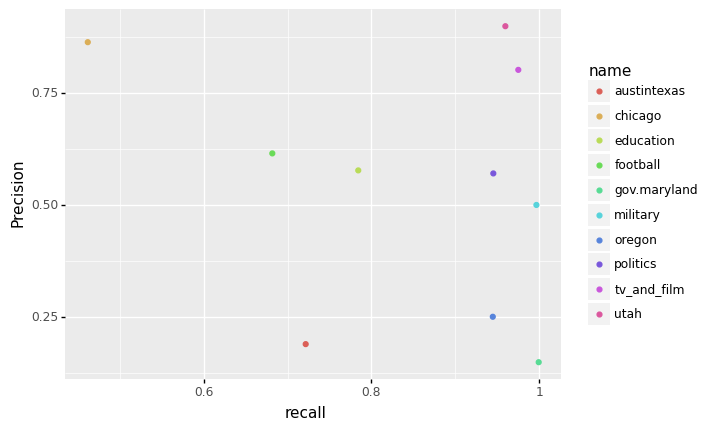

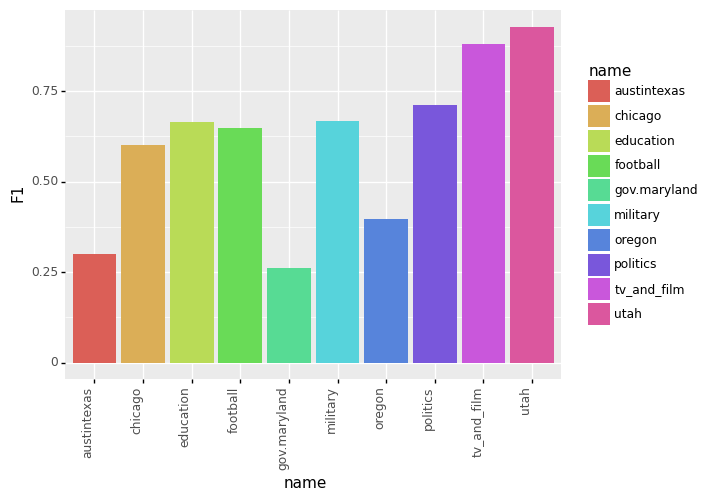


utah Precision 0.8502673796791443 recall 0.9676966292134831 ABS Recall: 7728.025280898876 F1 0.9051894022334136 threshold: -0.002087740384615385
tv_and_film Precision 0.8501835985312117 recall 0.879463155229172 ABS Recall: 4509.887060015194 F1 0.8645755538959422 threshold: -0.003839352721979286
politics Precision 0.9 recall 0.0038412291933418692 ABS Recall: 16.897567221510883 F1 0.007649808754781131 threshold: 0.004035289608745685
military Precision 0.6221045665122436 recall 0.06326558083187508 ABS Recall: 1884.8081841432224 F1 0.11485124320361659 threshold: 0.00010147505063291138
education Precision 1.0 recall 0.002320185614849188 ABS Recall: 6.424593967517401 F1 0.004629629629629629 threshold: 0.001643925661680092
football Precision 0.852760736196319 recall 0.05687397708674304 ABS Recall: 380.9987725040916 F1 0.10663598005370158 threshold: 0.0022950617880161104
chicago Precision 0.8508272121919407 recall 0.46311934832972124 ABS Recall: 196930.85113220237 F1 0.5997725568003097 thresh

/tmp/ipykernel_4162/1740601294.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_4162/1740601294.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_4162/1740601294.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


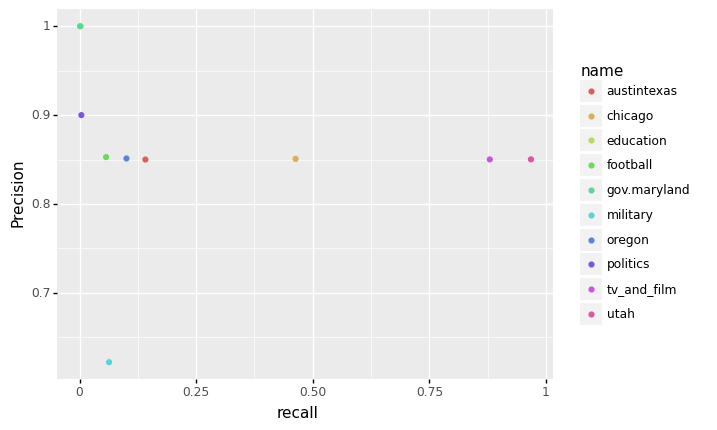

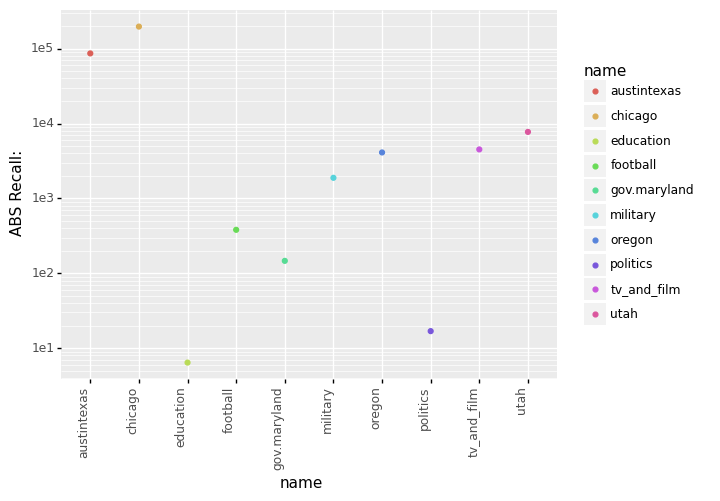

In [25]:
def printBestForTargetPrecision(dfOriginal):
    df = dfOriginal[dfOriginal['targetPrecisionPrecision:'] >= targetPrecision]
    if (len(df.index) > 0):
        df.sort_values(by=['targetPrecisionRecall:', 'targetPrecisionPrecision:'], inplace=True, ascending=False)
    else:
        df = dfOriginal
        df.sort_values(by=['targetPrecisionPrecision:', 'targetPrecisionRecall:'], inplace=True, ascending=False)
    if(len(df.index)>0):
        bestRow = df.iloc[0]
        curRow = {"name": name,'Precision': bestRow['targetPrecisionPrecision:'],'recall': bestRow['targetPrecisionRecall:'],'ABS Recall:': bestRow['targetPrecisionAbsRecall'], "F1": bestRow['targetPrecisionF1:'],'threshold:':
              bestRow['targetPrecisionBestThreshold:']}
        dfRowsForPlottingTargetPrecision.append(curRow)
        print(name, 'Precision', bestRow['targetPrecisionPrecision:'], 'recall', bestRow['targetPrecisionRecall:'],
              'ABS Recall:', bestRow['targetPrecisionAbsRecall'], "F1", bestRow['targetPrecisionF1:'], 'threshold:',
              bestRow['targetPrecisionBestThreshold:'])


print("-------------------------------------------Max F1--------------------------------------------------------------------------------------")
dfRowsForPlottingBestF1=[]
for name in dfF1['dataset'].unique():
    thisDF = dfF1[dfF1['dataset']==name]
    thisDF.sort_values(by=['best_F1'],inplace=True,ascending=False)
    bestRow = thisDF.iloc[0]
    print(name,'Precision',bestRow['precision'],'Recall',bestRow['recall'],'Best F1',bestRow['best_F1'],"threshold",bestRow['bestThreshold'])
    curRow = {"name": name,'Precision': bestRow['precision'],'recall': bestRow['recall'], "F1": bestRow['best_F1'],'threshold:':bestRow['bestThreshold']}
    dfRowsForPlottingBestF1.append(curRow)
    #print(thisDF.iloc[0])
print("-------------------------------------------Target Precision--------------------------------------------------------------------------------------")
plottingDFMaxF1 = pd.DataFrame(dfRowsForPlottingBestF1)
plottingDFMaxF1.to_csv("localData/bestF1ScoreBased.csv")
print(ggplot(plottingDFMaxF1) + geom_point(aes(x='recall',y='Precision',color="name")))
plot = ggplot(plottingDFMaxF1,aes(x = 'name',y='F1',fill='name')) + geom_col(position=position_dodge()) + theme(axis_text_x = element_text(angle=90, hjust=1))
print(plot)

dfRowsForPlottingTargetPrecision = []
for name in dfF1['dataset'].unique():
    thisDF = dfF1[dfF1['dataset']==name]
    printBestForTargetPrecision(thisDF)

plottingDF = pd.DataFrame(dfRowsForPlottingTargetPrecision)
print(dfRowsForPlottingTargetPrecision)
print(ggplot(plottingDF) + geom_point(aes(x='recall',y='Precision',color="name")))
print(ggplot(plottingDF) + geom_point(aes(y='ABS Recall:',x="name", color="name")) + theme(axis_text_x = element_text(angle=90, hjust=1)) + scale_y_log10())
plottingDF.to_csv("localData/targetPrecisionScoreBased.csv")
    #Best without precision=1:
# print("-------------------------------------------Target Precision without 1.0 --------------------------------------------------------------------------------------")
# for name in dfF1['dataset'].unique():
#     thisDF = dfF1[dfF1['dataset']==name]
#     newDF = thisDF[thisDF['targetPrecisionPrecision:'] <1.0]
#     print(len(newDF.index),len(thisDF.index))
#     printBestForTargetPrecision(newDF)
#     #Best without precision=1:
#     #print(thisDF.iloc[0])

In [ ]:
for name in dfF1['dataset'].unique():
    thisDF = dfF1[dfF1['dataset']==name]
    list = thisDF['targetPrecisionPrecision:'].unique()
    list.sort()
    print(name,list)

In [10]:
def getDF(dfList,name):
    return list(filter(lambda x: x.iloc[0]['dataset']==name, dfList))[0]

In [16]:
dsName = "education"
originalDF = getDF(allDfsFiltered, dsName)
thisDF = dfF1[dfF1['dataset'] == dsName]
thisDF.sort_values(by=['targetPrecisionRecall:'],inplace=True,ascending=False)
bestRow = thisDF.iloc[0]
print(name,'Precision',bestRow['targetPrecisionPrecision:'],'recall',bestRow['targetPrecisionRecall:'],'ABS Recall:',bestRow['targetPrecisionAbsRecall'],"F1",bestRow['targetPrecisionF1:'])
weights=[bestRow.strongPositiveWeight,bestRow.weakPositiveWeight,bestRow.neutralWeight,bestRow.weakNegativeWeight,bestRow.strongNegativeWeight]
originalDF['score'] = createScore(weights,originalDF)
originalDF.sort_values(by=['score'],inplace=True,ascending=False)
originalDF = originalDF[originalDF['score'] >= bestRow['targetPrecisionBestThreshold:']]
print(weights)
originalDF

military Precision 0.5625 recall 0.1651376146788991 ABS Recall: 51.522935779816514 F1 0.2553191489361702
[1.0, 1.0, 0, -0.6, -1.0]


/tmp/ipykernel_4736/3358552528.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_4736/3358552528.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_4736/3358552528.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Vertex1ID,Vertex2ID,trainEndDate,remainsValidFullTimeSpan,hasChangeAfterTrainPeriod,interestingnessEvidence,evalEndDateOneTimeUnitAfterTrain,remainsValidOneTimeUnitAfterTrain,isInterestingOneTimeUnitAfterTrain,interestingnessEvidenceOneTimeUnitAfterTrain,...,weakPositive_scoreSum,neutral_scoreSum,weakNegative_scoreSum,strongNegative_scoreSum,dataset,datasetAbbreviated,datasource,isInterstingStrict,isInterstingStrictOneTimeUnit,score
14627,infobox school||11276244||268124147-0||funding...,infobox school||11276244||268124147-0||schooltype,2017-04-29,False,True,1,2017-05-06,True,False,0,...,0.005970,735.0,0.0,6.0,education,ED,wikipedia,True,False,-0.006706
11053,infobox book||949027||66691030-1||series,infobox book||949027||66691030-3||series,2017-04-29,True,True,3,2017-05-06,True,False,0,...,1.666667,717.0,3.0,10.0,education,ED,wikipedia,True,False,-0.011277
64200,infobox_university||8009605||98898689-0||free,infobox_university||8009605||98898689-0||nickname,2017-04-29,False,True,6,2017-05-06,True,False,0,...,9.000000,692.0,0.0,24.0,education,ED,wikipedia,True,False,-0.016110
11045,infobox book||949027||66691030-0||series,infobox book||949027||66691030-2||series,2017-04-29,True,True,3,2017-05-06,True,False,0,...,1.333333,712.0,9.0,12.0,education,ED,wikipedia,True,False,-0.018105
10866,infobox book||8880905||100138218-0||genre,infobox book||8894042||100325908-0||genre,2017-04-29,False,True,1,2017-05-06,True,False,0,...,0.218824,712.0,8.0,14.0,education,ED,wikipedia,True,False,-0.021190
10921,infobox book||8894042||100325908-0||genre,infobox book||8922737||100700080-0||genre,2017-04-29,False,True,2,2017-05-06,True,False,0,...,0.218824,708.0,9.0,15.0,education,ED,wikipedia,True,False,-0.023032
10818,infobox book||8834736||99489156-0||genre_🔗_ext...,infobox book||8835489||99498908-0||genre_🔗_ext...,2017-04-29,False,True,1,2017-05-06,True,False,0,...,0.038200,705.0,11.0,15.0,education,ED,wikipedia,True,False,-0.024783
45411,infobox school||23519990||300735651-0||type,infobox school||23683323||303262437-0||type,2017-04-29,False,True,1,2017-05-06,True,False,0,...,0.000743,708.0,19.0,15.0,education,ED,wikipedia,True,False,-0.030378
62419,infobox university||16138032||196322691-0||image,infobox_university||16336748||198670942-0||image,2017-04-29,True,True,1,2017-05-06,True,False,0,...,0.171429,697.0,16.0,19.0,education,ED,wikipedia,True,False,-0.032610
38963,infobox school||23506197||300523577-0||type_🔗_...,infobox school||23519990||300735651-0||type_🔗_...,2017-04-29,False,True,1,2017-05-06,True,False,0,...,0.001360,701.0,20.0,18.0,education,ED,wikipedia,True,False,-0.034520


In [50]:
#check thresholds:
curDS = allDfsFiltered[0]
dsName = curDS.iloc[0]['datasetAbbreviated']
thisDF = dfF1[dfF1['dataset']==dsName]
print(dsName)
thisDF.sort_values(by=['best_F1'],inplace=True,ascending=False)
bestRow = thisDF.iloc[0]
print(dsName,'Precision',bestRow['precision'],'Recall',bestRow['recall'],'Best F1',bestRow['best_F1'],"threshold",bestRow["bestThreshold"])
weights = [bestRow["strongPositiveWeight"],bestRow["weakPositiveWeight"],bestRow["neutralWeight"],bestRow["weakNegativeWeight"],bestRow["strongNegativeWeight"]]
curDS["bestScore"] = createScore(weights,curDS)
curDS["bestScoreChosen"] = curDS["bestScore"] >= bestRow["bestThreshold"]
curDS["bestScoreModified"] = curDS["bestScore"] - bestRow["bestThreshold"]
curDS["bestScoreModifiedChosen"] = curDS["bestScore"] > 0
print(len(curDS[curDS["bestScoreChosen"]].index))
print(len(curDS[curDS["bestScoreModifiedChosen"]].index))
 # dict1 = {"dataset": dsName,
    #          "scoreName": scoreName,
    #          "bestThreshold": thresholds[bestThresholdIndex],
    #          "best_F1":f1_scores[bestThresholdIndex],#np.max(f1_scores),
    #          "precision":precision[bestThresholdIndex],
    #          "recall":recall[bestThresholdIndex],
    #          "strongPositiveWeight":curWeights[0],
    #          "weakPositiveWeight":curWeights[1],
    #          "neutralWeight":curWeights[2],
    #          "weakNegativeWeight":curWeights[3],
    #          "strongNegativeWeight":curWeights[4],
    #          "pr":curRatio['pr'],
    #          "nr":curRatio['nr'],
    #          "nTOp":curRatio['nTOp'],
    #          "ThresholdRange":thisRange,
    #          "ThresholdRangeMax":maxRange,
    #          "ThresholdRangeAvg":avgRange
    #         }

AU
AU Precision 0.19067709199800367 Recall 0.7248213495225447 Best F1 0.3019269523069426 threshold -0.00048555851923076925


/home/leon.bornemann/dataset_versioning/finalExperiments/code/RoleMatchingEvaluation/plotting/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/leon.bornemann/dataset_versioning/finalExperiments/code/RoleMatchingEvaluation/plotting/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/leon.bornemann/dataset_versioning/finalExperiments/code/RoleMatchingEvaluation/plotting/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is tr

300550
21571


In [51]:
dfF1

,dataset,scoreName,targetPrecisionBestThreshold:,targetPrecisionPrecision:,targetPrecisionRecall:,targetPrecisionF1:,targetPrecisionAbsRecall,bestThreshold,best_F1,precision,...,weakPositiveWeight,neutralWeight,weakNegativeWeight,strongNegativeWeight,pr,nr,nTOp,ThresholdRange,ThresholdRangeMax,ThresholdRangeAvg
2526,utah,score_pr:0.2_nr:1.0_nTOp:0.01,-0.002451,0.850123,0.999148,0.918631,7180.878194,-0.000564,0.939391,0.892501,...,0.20000,0,-0.01000,-0.01,0.2000,1.0000,0.01,2.132997e-06,0.003663,0.000063
2596,utah,score_pr:0.1_nr:0.8_nTOp:0.01,-0.002390,0.850246,0.999148,0.918703,7180.878194,-0.000556,0.939362,0.892863,...,0.10000,0,-0.00800,-0.01,0.1000,0.8000,0.01,9.850036e-06,0.004095,0.000060
2589,utah,score_pr:0.1_nr:1.0_nTOp:0.01,-0.002451,0.850123,0.999148,0.918631,7180.878194,-0.000568,0.939362,0.892863,...,0.10000,0,-0.01000,-0.01,0.1000,1.0000,0.01,3.424371e-06,0.004095,0.000060
2785,utah,score_pr:0.0001_nr:0.8_nTOp:0.01,-0.002390,0.850246,0.999148,0.918703,7180.878194,-0.000559,0.939352,0.892983,...,0.00010,0,-0.00800,-0.01,0.0001,0.8000,0.01,1.833161e-07,0.008240,0.000059
2659,utah,score_pr:0.01_nr:0.8_nTOp:0.01,-0.002390,0.850246,0.999148,0.918703,7180.878194,-0.000559,0.939352,0.892983,...,0.01000,0,-0.00800,-0.01,0.0100,0.8000,0.01,3.780700e-07,0.008041,0.000059
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1617,gov.maryland,score_pr:0.001_nr:0.01_pTOn:0.01,-0.036346,1.000000,0.000813,0.001625,114.352992,-0.321428,0.258845,0.148662,...,0.00001,0,-0.01000,-1.00,0.0010,0.0100,100.00,1.745597e-10,0.044094,0.000171
1509,gov.maryland,score_pr:0.1_nr:0.0001_nTOp:0.5,0.187637,1.000000,0.001004,0.002007,141.259578,-0.160697,0.258845,0.148662,...,0.10000,0,-0.00005,-0.50,0.1000,0.0001,0.50,1.895962e-07,0.026549,0.000223
1508,gov.maryland,score_pr:0.1_nr:0.0001_nTOp:1.0,0.174035,1.000000,0.000957,0.001911,134.532932,-0.321412,0.258845,0.148662,...,0.10000,0,-0.00010,-1.00,0.1000,0.0001,1.00,1.895962e-07,0.051275,0.000308
1507,gov.maryland,score_pr:0.1_nr:0.0001_pTOn:0.2,0.004383,1.000000,0.000813,0.001625,114.352992,-0.321425,0.258845,0.148662,...,0.02000,0,-0.00010,-1.00,0.1000,0.0001,5.00,3.791923e-08,0.047727,0.000197


# Weight Transfer

In [31]:
def transferWeights(dsName,allDfs,printDetailed=False):
    if(printDetailed):
        print("-------------------------------------------------------------------------------------")
    print("Executing with ",dsName,"as the calibration dataset")
    if(printDetailed):
        print("-------------------------------------------------------------------------------------")
    otherDatasets = [ x for x in allDfs if x.iloc[0].dataset != dsName]
    dfF1ForThisDs = dfF1[dfF1['dataset']==dsName]
    best = dfF1ForThisDs.sort_values(by=['best_F1'],ascending=False).iloc[0]
    avgF1RetainedPercentages = 0.0
    for otherDataset in otherDatasets:
        otherDsName = otherDataset.iloc[0].dataset
        dfF1ForOtherDs = dfF1[dfF1['dataset']==otherDsName]
        bestOther = dfF1ForOtherDs.sort_values(by=['best_F1'],ascending=False).iloc[0]
        #print(bestOther.scoreName)
        #print(bestOther.bestThreshold)
        #print("-------------------------------------------------------------------------------------")
        #Now: Transfer weights and Threshold and see how good we are!
        transferredWeights = [best.strongPositiveWeight,best.weakPositiveWeight,best.neutralWeight,best.weakNegativeWeight,best.strongNegativeWeight]
        transferredThreshold = best.bestThreshold
        scoreVector = createScore(transferredWeights,otherDataset)
        y_pred = scoreVector > transferredThreshold
        y_test = otherDataset['remainsValidFullTimeSpan']
        transferredF1 = f1_score(y_test,y_pred)
        retainedF1Percentage = 100 * transferredF1 / bestOther.best_F1 
        avgF1RetainedPercentages = avgF1RetainedPercentages + retainedF1Percentage
        if(printDetailed):
            print("-------------------------------------------------------------------------------------")
            print(otherDsName)
            print("Best F1",bestOther.best_F1)
            print("Transferred F1",transferredF1)
            print("F1 retained [%]: ",retainedF1Percentage,"%")
        #print("-------------------------------------------------------------------------------------")
    print('avgF1RetainedPercentages',avgF1RetainedPercentages/len(otherDatasets))

def transferWeightsBetween(fromDs,toDs,printDetailed=False):
    #transfer from:
    fromDsName = fromDs.iloc[0].datasetAbbreviated
    dfF1ForThisDs = dfF1[dfF1['dataset']==fromDsName]
    #print(fromDsName,len(dfF1ForThisDs.index))
    best = dfF1ForThisDs.sort_values(by=['best_F1'],ascending=False).iloc[0]
    #transfer to:
    otherDsName = toDs.iloc[0].datasetAbbreviated
    dfF1ForOtherDs = dfF1[dfF1['dataset']==otherDsName]
    bestOther = dfF1ForOtherDs.sort_values(by=['best_F1'],ascending=False).iloc[0]
    #print(bestOther.scoreName)
    #print(bestOther.bestThreshold)
    #print("-------------------------------------------------------------------------------------")
    #Now: Transfer weights and Threshold and see how good we are!
    transferredWeights = [best.strongPositiveWeight,best.weakPositiveWeight,best.neutralWeight,best.weakNegativeWeight,best.strongNegativeWeight]
    transferredThreshold = best.bestThreshold
    scoreVector = createScore(transferredWeights,toDs)
    y_pred = scoreVector > transferredThreshold
    y_test = toDs['remainsValidFullTimeSpan']
    transferredF1 = f1_score(y_test,y_pred)
    transferredPrecision = precision_score(y_test,y_pred)
    transferredRecall = recall_score(y_test,y_pred)
    retainedF1Percentage = 100 * transferredF1 / bestOther.best_F1 
    # if(fromDsName == 'football' or fromDsName == 'chicago'):
    #     print("-------------------------------------------------------------------------------------")
    #     print(fromDsName," To:",otherDsName)
    #     print("Best F1",bestOther.best_F1)
    #     print("Transferred F1",transferredF1)
    #     print("Transferred Precision",transferredPrecision)
    #     print("Transferred Recall",transferredRecall)
    #     print("F1 retained [%]: ",retainedF1Percentage,"%")
    return retainedF1Percentage
    
def runForList(dsList):
    print("-------------------------------------------------------------------------------------")
    print(dsList[0].iloc[0].datasource)
    print("-------------------------------------------------------------------------------------")
    print(','.join(map(lambda x: str(x.iloc[0].dataset),dsList)))
    for ds in dsList:
        dsName = ds.iloc[0].dataset
        print(dsName,end='')
        for otherDs in dsList:
            print(",",end='')
            otherDsName = otherDs.iloc[0].dataset
            if(otherDsName==dsName):
                print("-",end='')
            else:
                print(round(transferWeightsBetween(ds,otherDs),2),end='')
        print("\n")
        
allDfsWikipedia = list(filter(lambda x: x.iloc[0].datasource == 'wikipedia', allDfsFiltered))
allDfsSocrata = list(filter(lambda x: x.iloc[0].datasource == 'socrata', allDfsFiltered))

runForList(allDfsWikipedia)
runForList(allDfsSocrata)

#print best weight settings:
datasetNames = dfF1['dataset'].unique()
print(datasetNames)
bestSocrata="CH"
dfF1ForThisDs = dfF1[dfF1['dataset']==bestSocrata]
best = dfF1ForThisDs.sort_values(by=['best_F1'],ascending=False).iloc[0]
print("bestSocrata")
print(best)

bestWikipedia="MI"
dfF1ForThisDs = dfF1[dfF1['dataset']==bestWikipedia]
best = dfF1ForThisDs.sort_values(by=['best_F1'],ascending=False).iloc[0]
print("bestWikipedia:")
print(best)



#transferWeights('chicago',allDfsSocrata)

#print(withoutOther)
#print(best)


    
#Wikipedia:
#for dsName in wikipediaNames:
#    withoutOther = [ x for x in wikipediaNames if x != dsName]
#    dfF1ForThisDs = dfF1[dfF1['dataset']==dsName]
#    best = dfF1.sort_values(by=['best_F1'],inplace=True,ascending=False).iloc[0]


-------------------------------------------------------------------------------------
wikipedia
-------------------------------------------------------------------------------------
politics,military,football,tv_and_film,education
politics,-,60.16,57.33,83.0,95.58

military,96.77,-,65.93,98.95,95.33

football,77.56,12.41,-,7.04,21.37

tv_and_film,95.74,99.32,65.4,-,94.58

education,98.52,92.98,64.18,95.37,-

-------------------------------------------------------------------------------------
socrata
-------------------------------------------------------------------------------------
austintexas,chicago,gov.maryland,oregon,utah
austintexas,-,24.78,98.34,60.53,99.29

chicago,83.0,-,78.66,67.57,99.43

gov.maryland,89.57,19.6,-,97.82,97.07

oregon,88.28,19.34,98.74,-,98.73

utah,72.18,19.4,91.95,57.99,-

['UT', 'MI', 'TV', 'CH', 'ED', 'PO', 'FO', 'OR', 'AU', 'MD']
Categories (10, object): ['UT', 'MI', 'TV', 'CH', ..., 'FO', 'OR', 'AU', 'MD']
bestSocrata
dataset                           

# Json Export Of Weight Settings

In [32]:
#print best weight settings:
datasetNames = dfF1['dataset'].unique()
print(datasetNames)
for dsName in datasetNames:
    dfF1ForThisDs = dfF1[dfF1['dataset']==dsName]
    best = dfF1ForThisDs.sort_values(by=['best_F1'],ascending=False).iloc[0]
    print("-------------------------------------------------------------------------")
    print(dsName)
    print("{")
    print("\"alpha\" : ",best.bestThreshold,",")
    print("\"strongPositiveWeight\" : ",best.strongPositiveWeight,",")
    print("\"weakPositiveWeight\" : ",best.weakPositiveWeight,",")
    print("\"neutralWeight\" : ",best.neutralWeight,",")
    print("\"weakNegativeWeight\" : ",best.weakNegativeWeight,",")
    print("\"strongNegativeWeight\" : ",best.strongNegativeWeight,",")
    print("\"eventCountInLineage\" : 869")
    print("}")

['UT', 'MI', 'TV', 'CH', 'ED', 'PO', 'FO', 'OR', 'AU', 'MD']
Categories (10, object): ['UT', 'MI', 'TV', 'CH', ..., 'FO', 'OR', 'AU', 'MD']
-------------------------------------------------------------------------
UT
{
"alpha" :  -0.0005637782203296703 ,
"strongPositiveWeight" :  1.0 ,
"weakPositiveWeight" :  0.2 ,
"neutralWeight" :  0 ,
"weakNegativeWeight" :  -0.01 ,
"strongNegativeWeight" :  -0.01 ,
"eventCountInLineage" : 869
}
-------------------------------------------------------------------------
MI
{
"alpha" :  -0.09689141870779747 ,
"strongPositiveWeight" :  0.1 ,
"weakPositiveWeight" :  0.001 ,
"neutralWeight" :  0 ,
"weakNegativeWeight" :  -0.8 ,
"strongNegativeWeight" :  -1.0 ,
"eventCountInLineage" : 869
}
-------------------------------------------------------------------------
TV
{
"alpha" :  -0.000974212 ,
"strongPositiveWeight" :  1.0 ,
"weakPositiveWeight" :  0.6 ,
"neutralWeight" :  0 ,
"weakNegativeWeight" :  -0.008 ,
"strongNegativeWeight" :  -0.01 ,
"eventCountIn

In [ ]:
dfF1
# Define ratios:
dfF1['weakToStrongNegativeWeightRelation']=dfF1['weakNegativeWeight']/dfF1['strongNegativeWeight']
dfF1['weakToStrongPositiveWeightRelation']=dfF1['weakPositiveWeight']/dfF1['strongPositiveWeight']
dfF1['weakToWeakWeightRelation']=dfF1['weakPositiveWeight']/(-dfF1['weakNegativeWeight'])
dfF1['strongToStrongWeightRelation']=dfF1['strongPositiveWeight']/(-dfF1['strongNegativeWeight'])
dfF1['nTOpAsData']=dfF1['nTOp']
dfF1['nrAsData']=dfF1['nr']
dfF1['nToP']=dfF1['nTOpAsData'].astype('category')
dfF1['nr']=dfF1['nrAsData'].astype('category')

#Some preprocessing to make the plots look nicer:
dfF1Wikipedia = dfF1[dfF1['dataset'].isin(['politics', 'military', 'football', 'tv_and_film', 'education'])]
dfF1Socrata = dfF1[dfF1['dataset'].isin(['utah', 'chicago', 'austintexas', 'oregon', 'gov.maryland'])]
datasetToAbbreviation = {
'austintexas' : 'AU',
'chicago' : 'CH',
'gov.maryland' : 'MD',
'oregon' : 'OR',
'utah' : 'UT',
'education' : 'ED',
'football' : 'FO',
'military' : 'MI',
'politics' : 'PO',
'tv_and_film' : 'TV'
}

aggregateStatSocrataDF['datasource'] = "socrata"
aggregateStatWikipediaDF['datasource'] = "wikipedia"

dfF1Backup = dfF1.copy(True)
dfF1

In [39]:
dfF1["dataset"] = dfF1["dataset_long"]

In [40]:
dfF1['dataset_long']=dfF1['dataset']
dfF1['dataset_unordered']= list(map(lambda x : datasetToAbbreviation[x],list(dfF1['dataset_long'])))
dfF1['dataset'] = pd.Categorical(dfF1['dataset_unordered'], ["AU","CH","MD","OR","UT","ED","FO","MI","PO","TV"])
dfF1

,dataset,scoreName,targetPrecisionBestThreshold:,targetPrecisionPrecision:,targetPrecisionRecall:,targetPrecisionF1:,targetPrecisionAbsRecall,bestThreshold,best_F1,precision,...,ThresholdRangeAvg,weakToStrongNegativeWeightRelation,weakToStrongPositiveWeightRelation,weakToWeakWeightRelation,strongToStrongWeightRelation,nTOpAsData,nrAsData,nToP,dataset_long,dataset_unordered
1203,FO,score_pr:0.8_nr:1.0_nTOp:0.01,0.004806,0.863636,0.251656,0.389744,77.006623,-0.000632,0.785924,0.705263,...,0.000143,1.0,0.8,80.00,100.00,0.01,1.0,0.01,football,FO
1266,FO,score_pr:0.6_nr:1.0_nTOp:0.01,0.003562,0.851064,0.264901,0.404040,81.059603,-0.000623,0.784661,0.707447,...,0.000115,1.0,0.6,60.00,100.00,0.01,1.0,0.01,football,FO
1329,FO,score_pr:0.4_nr:1.0_nTOp:0.01,0.002808,0.872340,0.271523,0.414141,83.086093,-0.000687,0.782353,0.703704,...,0.000092,1.0,0.4,40.00,100.00,0.01,1.0,0.01,football,FO
1455,FO,score_pr:0.1_nr:1.0_nTOp:0.01,0.001571,0.850000,0.225166,0.356021,68.900662,-0.000650,0.780781,0.714286,...,0.000069,1.0,0.1,10.00,100.00,0.01,1.0,0.01,football,FO
1140,FO,score_pr:1.0_nr:1.0_nTOp:0.01,0.005971,0.860465,0.245033,0.381443,74.980132,-0.000670,0.780347,0.692308,...,0.000170,1.0,1.0,100.00,100.00,0.01,1.0,0.01,football,FO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
760,MI,score_pr:0.4_nr:1.0_nTOp:0.5,0.000345,1.000000,0.006024,0.011976,4.319277,-0.050035,0.406360,0.287500,...,0.000346,1.0,0.4,0.80,2.00,0.50,1.0,0.50,military,MI
567,MI,score_pr:1.0_nr:1.0_pTOn:0.01,-0.005752,1.000000,0.012048,0.023810,8.638554,-0.100115,0.406360,0.287500,...,0.000685,1.0,1.0,0.01,0.01,100.00,1.0,100.00,military,MI
568,MI,score_pr:1.0_nr:1.0_pTOn:0.1,-0.005740,1.000000,0.012048,0.023810,8.638554,-0.100110,0.406360,0.287500,...,0.000691,1.0,1.0,0.10,0.10,10.00,1.0,10.00,military,MI
569,MI,score_pr:1.0_nr:1.0_pTOn:0.2,-0.005726,1.000000,0.012048,0.023810,8.638554,-0.100106,0.406360,0.287500,...,0.000691,1.0,1.0,0.20,0.20,5.00,1.0,5.00,military,MI


# Tuning Plots (Boxplot + Scatterplot)

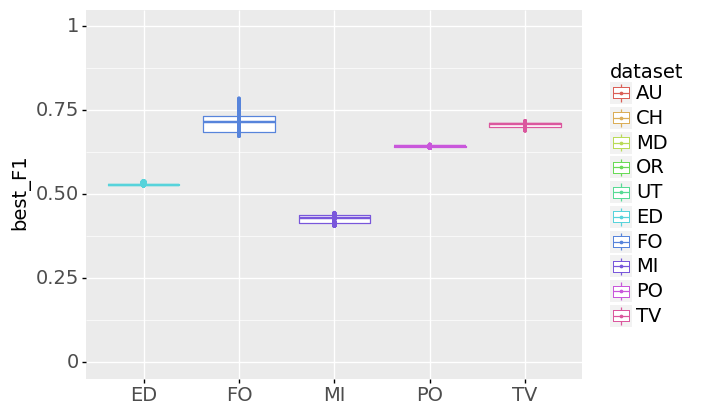

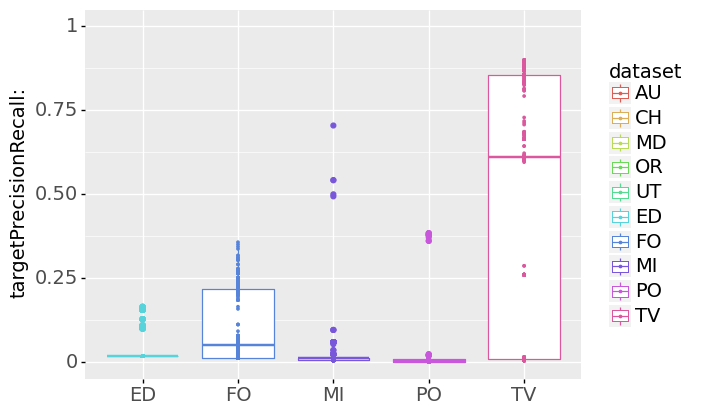

In [41]:
# The actual plotting function for boxplots:
def printBoxplot(df,datasource):
    p = (ggplot(df,aes(ymin=0,ymax=1,x='dataset',y='best_F1',color='dataset'))
    + geom_boxplot()
    + geom_point(size=0.5)
    + theme(text=element_text(size=14))#,axis_text_x=element_text(rotation=45, hjust=1))
    + labs(x="")
    )
    print(p)
    p2 = (ggplot(df,aes(ymin=0,ymax=1,x='dataset',y='targetPrecisionRecall:',color='dataset'))
    + geom_boxplot()
    + geom_point(size=0.5)
    + theme(text=element_text(size=14))#,axis_text_x=element_text(rotation=45, hjust=1))
    + labs(x="")
    )
    print(p2)
    #fname = 'exportedPlots/bestTunedF1' + datasource +'.jpg'
    #p.save(filename = fname)

printBoxplot(dfF1,"both")

scatterPlotWidth=4
scatterPlotHeight=4
textSizeScatterPlot=16

datasetNames=dfF1['dataset'].unique()
#plot the three datasets that are interesting:
# for dsName in ['AU','CH','PO']:
#     curDF = dfF1[dfF1['dataset']==dsName]
#     nrPlot = ggplot(curDF, aes(x='nrAsData',ymin=0,ymax=1, y='best_F1',color='pr',shape='nToP')) + scale_x_log10() + geom_point(size=2)  + labs(title = dsName,x="nr") + theme(text=element_text(size=textSizeScatterPlot)) + theme(figure_size = (scatterPlotWidth, scatterPlotHeight))
#     nTOpPlot = ggplot(curDF, aes(x='nTOpAsData',ymin=0,ymax=1, y='best_F1',color='pr',shape='nr')) + scale_x_log10() + geom_point(size=2)  + labs(title= dsName,x="nToP") + theme(text=element_text(size=textSizeScatterPlot)) + theme(figure_size = (scatterPlotWidth, scatterPlotHeight))
#     print(nrPlot)
#     print(nTOpPlot)
#     fname = 'exportedPlots/tuningResult_nr_' + dsName +'.jpg'
#     nrPlot.save(filename = fname)
#     fname = 'exportedPlots/tuningResult_nToP_' + dsName +'.jpg'
#     nTOpPlot.save(filename = fname)